In [1]:
# Third-party
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream, streakline_stream
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic
from matplotlib import cm

from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp
from scipy.optimize import minimize

# Density model class:

In [4]:
from density import get_projected_coords, get_u_v, get_uniform_idx, DensityModel2D
from likelihood import z_to_a, a_to_z

## Make fake data where we know the answer:

In [5]:
from sklearn.mixture import GaussianMixture

In [6]:
D = 2
h = 1.

In [207]:
rnd = np.random.RandomState(22)
true_K = 10
true_nodes = np.stack((np.linspace(0, 10, true_K),
                       np.zeros(true_K))).T
true_nodes[4, 1] += 0.75
true_s = rnd.uniform(0.5, 1., size=true_K)

true_z = rnd.uniform(0.8, 0.95, size=true_K-1)
true_a = z_to_a(true_z)
assert np.isclose(true_a.sum(), 1.)

# Sample from truth:
C = np.zeros((true_K, D, D))
C[:, 0, 0] = h**2
C[:, 1, 1] = true_s**2

P = np.zeros_like(C)
for k in range(true_K):
    P[k] = np.linalg.cholesky(np.linalg.inv(C[k]))

gmm = GaussianMixture(n_components=true_K, covariance_type='full')
gmm.fit(np.random.random(size=(true_K+1, 2)))
gmm.weights_ = true_a
gmm.covariances_ = C
gmm.precisions_cholesky_ = P
gmm.means_ = true_nodes

X = gmm.sample(n_samples=8000)[0]

In [208]:
true_dens_model = DensityModel2D(X)
true_dens_model.poly = np.poly1d([0.])
track = true_dens_model.get_dense_poly_track(size=10000)
nodes = true_dens_model.set_nodes(track=track, nodes=true_nodes)

In [209]:
dens_model = DensityModel2D(X)
track = dens_model.get_dense_poly_track(size=10000)
nodes = dens_model.set_nodes(spacing=1.5, track=track)

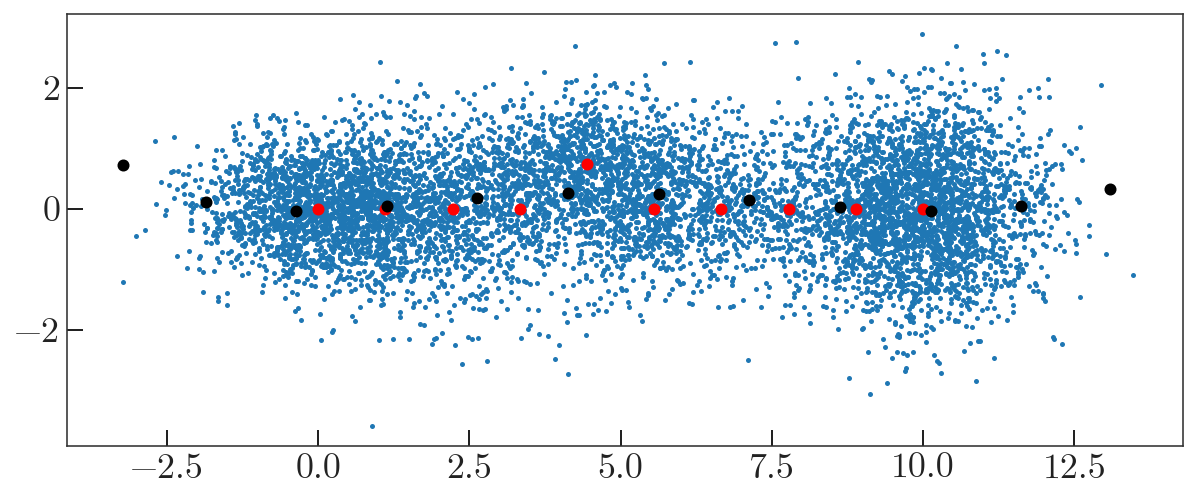

In [210]:
plt.figure(figsize=(10, 4))
plt.plot(X[:, 0], X[:, 1], marker='.', ls='none')
plt.scatter(true_nodes[:, 0], true_nodes[:, 1], zorder=10, color='r')
plt.scatter(nodes[:, 0], nodes[:, 1], zorder=10, color='k')
plt.gca().set_aspect('equal')

## Probabilistic model class

A lesson in over-engineering

In [211]:
K = dens_model.K

In [212]:
# ak0 = np.ones(dens_model.K) / dens_model.K
# assert np.isclose(np.sum(ak0), 1.)
# ln_ak0 = np.log(ak0)

sk0 = 0.5 * np.ones(dens_model.K)
# sk0 = true_s

In [213]:
# z0 = np.ones(K-1)
# z0 = true_z

z0 = a_to_z(np.ones(K)/K)

In [214]:
m0 = np.zeros(K)

In [156]:
def z_to_a(zj):
    K = len(zj) + 1
    a = np.zeros(K)
    a[0] = 1 - zj[0]
    for k in range(1, K-1):
        a[k] = np.prod(zj[:k]) * (1 - zj[k])
    a[K-1] = np.prod(zj)
    return a


def a_to_z(ak):
    K = len(ak)
    z = np.zeros(K - 1)
    z[0] = 1 - ak[0]
    for i in range(1, K-1):
        z[i] = 1 - ak[i] / np.prod(z[:i])
    return z


def ln_normal(x, mu, var):
    return -0.5*np.log(2*np.pi) - 0.5*np.log(var) - 0.5 * (x-mu)**2 / var


class Model:

    def __init__(self, density_model, h, l=None, frozen=None):
        if frozen is None:
            frozen = dict()
        self.frozen = dict(frozen)
        
        if density_model.K is None:
            raise ValueError('Density model not initialized')
        self.density_model = density_model
        self._X = density_model.X
        self._K = self.density_model.K
        
        self.h = h
        if l is None: # width of prior on m
            l = self.h
        self.l = l
        
        self._params = dict()
        self._params['ln_z'] = (self.density_model.K-1, )
        self._params['ln_s'] = (self.density_model.K, )
        self._params['m'] = (self.density_model.K, )

    def pack_pars(self, **kwargs):
        vals = []
        for k in sorted(list(self._params.keys())):
            frozen_val = self.frozen.get(k, None)
            val = kwargs.get(k, frozen_val)
            if val is None:
                raise ValueError("No value passed in for parameter {0}, but "
                                 "it isn't frozen either!".format(k))
            vals.append(val)
        return np.concatenate(vals)

    def unpack_pars(self, p):
        key_vals = []
        
        j = 0
        for name in sorted(list(self._params.keys())):
            shape = self._params[name]
            size = np.prod(shape)
            if name in self.frozen:
                key_vals.append((name, self.frozen[name]))
            else:
                key_vals.append((name, p[j:j+size]))
                j += size

        return dict(key_vals)
    
    def get_a(self, p):
        zj = np.exp(p['ln_z'])
        return z_to_a(zj)
        # return z_to_a(p['z'])
        
    def get_mu(self, p):
        mu = self.density_model.nodes.copy()
        mu[:, 1] = mu[:, 1] + p['m']
        return mu
    
    def get_s(self, p):
        s = np.exp(p['ln_s'])
        return s
        # return p['s']

    # =========================================================================
    # Probability functions:
    #

    def ln_prior(self, p):
        lp = 0.

        # if 'ln_a' not in self.frozen:
        #     if np.any(p['ln_a'] < -8) or np.any(p['ln_a'] > 0):
        #         return -np.inf
            
        # if 'ln_s' not in self.frozen:
        #     if np.any(p['ln_s'] < -5) or np.any(p['ln_s'] > 2.5):
        #         return -np.inf
        # if np.any(p['s'] < 0):
        #     return -np.inf
        
        # if np.any(p['z'] < 0) or np.any(p['z'] > 1):
        #     return -np.inf
        
        if np.any(p['ln_z'] > 0):
            return -np.inf
        
        lp += ln_normal(p['m'], 0, self.l).sum()

        return lp

    def ln_likelihood(self, p):
        s = self.get_s(p)
        a = self.get_a(p)
        mu = self.get_mu(p)
        return self.density_model.ln_density(self._X, a, s, self.h, 
                                             nodes=mu)

    def ln_posterior(self, p):
        # unpack parameter vector, p
        kw_pars = self.unpack_pars(p)

        lnp = self.ln_prior(kw_pars)
        if not np.isfinite(lnp):
            return -np.inf

        lnl = self.ln_likelihood(kw_pars)
        if not np.isfinite(lnl).all():
            return -np.inf

        return lnp + lnl.sum()

    def __call__(self, p):
        return self.ln_posterior(p)

In [157]:
model = Model(dens_model, h=h)

### Compute numerical derivatives

In [132]:
eps = 1e-7

num_derivs_s = []
for k in range(K):
    s1 = sk0.copy()
    s2 = s1.copy()
    s2[k] = s2[k] + eps
    _d = (model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': np.log(s2), 'm': m0}).sum() -
          model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': np.log(s1), 'm': m0}).sum()) / eps
    num_derivs_s.append(_d)
num_derivs_s = np.array(num_derivs_s)
num_derivs_s

array([  26.8482836 ,   53.29238775,   96.13111615,  156.53218725,
        230.25728296,  308.9170059 ,  384.18744225,  451.13214583,
        508.46741942,  557.08922446,  597.27884945,  624.68388933,
        629.36771428,  602.45605709,  546.14341934,  475.75100325,
        410.62485252,  364.8949496 ,  346.52621252,  360.25019654,
        411.25786083,  512.111219  ,  684.75637818,  941.79646112,
       1252.01389892, 1525.83306772, 1652.17366884, 1567.96486408,
       1300.07654661,  943.7668632 ,  602.60528699,  340.23774788,
        170.78978999,   75.84894774])

In [65]:
eps = 1e-6

num_derivs_z = []
for k in range(K - 1):
    z1 = z0.copy()
    z2 = z1.copy()
    z2[k] = z2[k] + eps

    _d = (model.ln_likelihood({'ln_z': np.log(z2), 'ln_s': np.log(sk0), 'm': m0}).sum() -
          model.ln_likelihood({'ln_z': np.log(z1), 'ln_s': np.log(sk0), 'm': m0}).sum()) / eps
    num_derivs_z.append(_d)
num_derivs_z = np.array(num_derivs_z)
num_derivs_z

array([2018.42296519, 1605.12789807, 1066.45301639,  461.23501852,
        -97.28512123, -488.00367949, -642.79111393, -578.66554198,
       -382.24084346, -164.40317268,  -12.47330874,   38.55382238,
          7.68029713,  -51.42878035,  -80.62738925,  -46.09008101,
         48.35402069,  168.27364743,  267.38281485,  305.63061591,
        261.21891278,  137.94623737,  -32.51888302, -198.57768712,
       -308.67684109, -334.71656207, -284.29048143, -193.0125818 ,
       -102.2905526 ,  -38.67697524])

In [109]:
eps = 1e-6

num_derivs_m = []
for k in range(K):
    m1 = m0.copy()
    m2 = m1.copy()
    m2[k] = m2[k] + eps

    _d = (model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': np.log(sk0), 'm': m2}).sum() -
          model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': np.log(sk0), 'm': m1}).sum()) / eps
    num_derivs_m.append(_d)
num_derivs_m = np.array(num_derivs_m)
num_derivs_m

array([ 0.79688652, -0.73477895, -3.10908763, -4.40076474, -2.72640682,
        2.02608862,  7.53235508, 10.76330409, 10.58175621,  8.02450086,
        4.54039582,  0.88714296, -2.63002948, -5.61028355, -7.39629104,
       -7.41462827, -5.65730443, -2.80401582,  0.09771611,  2.10533108,
        2.65512426,  1.50157211, -1.24745929, -4.59754119, -6.51395749,
       -5.21480615, -0.79245183,  4.79903611,  9.22026447, 11.17971624,
       10.91240665])

In [110]:
def derivs(density_model, z, s, m, h):
    nodes = density_model.nodes.copy()
    nodes[:, 1] = nodes[:, 1] + m
    
    R = density_model._R_k
    K = density_model.K
    X = density_model.X
    (N, D) = X.shape
    
    a = z_to_a(z)
    
    
    # We need this for all of the derivatives
    ln_N_nk = np.zeros((N, K))
    C = np.zeros((K, D, D))
    Cinv = np.zeros_like(C)
    for k in range(K):
        C[k] = density_model.get_Ck(k, s[k], h)
        Cinv[k] = np.linalg.inv(C[k])
        ln_N_nk[:, k] = mvn.logpdf(X, nodes[k], C[k], 
                                   allow_singular=True)
    ln_aN_nk = np.log(a) + ln_N_nk
    ln_denom = logsumexp(ln_aN_nk, axis=1)
    
    # ---
    
    ln_d_lnL_d_mk = np.zeros((N, K))
    signs = np.zeros((N, K))
    for k in range(K):
        # the [:,1] below picks off only the y term, because we only allow 
        # the means to move in y
        Cinv_dx = np.einsum('ij,nj->ni', Cinv[k], X - nodes[k:k+1])[:, 1]
        signs[:, k] = np.sign(Cinv_dx)
        log_Cinv_dx = np.log(np.abs(Cinv_dx))
        ln_d_lnL_d_mk[:, k] = ln_aN_nk[:, k] + log_Cinv_dx - ln_denom 
    
    ln_d_lnL_d_m, sign = logsumexp(ln_d_lnL_d_mk, b=signs, axis=0, return_sign=True)
    d_lnL_d_m = sign * np.exp(ln_d_lnL_d_m)
    
    # ---
    
    ln_last_K = ln_N_nk[:, -1]
    ln_d_lnL_d_a = logsumexp(ln_N_nk - ln_denom[:, None], axis=0)
    d_lnL_d_a = np.exp(ln_d_lnL_d_a)
    
    d_lnL_d_z = np.zeros(K-1)
    for k in range(K-1):
        term1 = a[k] / (z[k] - 1) * d_lnL_d_a[k]
        
        term2 = 0.
        for j in range(k+1, K):
            term2 += a[j] / z[k] * d_lnL_d_a[j]
        d_lnL_d_z[k] = term1 + term2
    
    # ---
    
    ln_d_lnL_d_sk = np.zeros((N, K))
    ln_s = np.log(s)
    signs = np.zeros((N, K))
    for k in range(K):
        b = X - nodes[k:k+1]
        
        # what APW derived:
        term = ((b[:, 1]*R[k,0,0] + b[:, 0]*R[k,0,1])**2/s[k]**2 - 1) / s[k]
        
        signs[:, k] = np.sign(term)
        log_term = np.log(np.abs(term))
        
        ln_d_lnL_d_sk[:, k] = ln_aN_nk[:, k] + log_term - ln_denom
    
    ln_d_lnL_d_s, sign = logsumexp(ln_d_lnL_d_sk, b=signs, axis=0, return_sign=True)
    d_lnL_d_s = sign * np.exp(ln_d_lnL_d_s)
    
    return d_lnL_d_m, d_lnL_d_s, d_lnL_d_z

In [111]:
exact_derivs_m, exact_derivs_s, exact_derivs_z = derivs(dens_model, z0, sk0, m0, h)

In [112]:
print(exact_derivs_m)
print(num_derivs_m)
assert np.all(np.abs((exact_derivs_m - num_derivs_m)/exact_derivs_m) < 1e-3)

[ 0.79687021 -0.73480418 -3.10912615 -4.40081773 -2.7264692   2.02601107
  7.53226568 10.76320269 10.58164565  8.02438047  4.54027007  0.8870185
 -2.6301522  -5.61039742 -7.39639225 -7.4147178  -5.65738546 -2.8040968
  0.09762262  2.10520847  2.65495886  1.50134906 -1.24774838 -4.5978919
 -6.51435335 -5.21521433 -0.79283317  4.79871296  9.22002166 11.17955007
 10.91230189]
[ 0.79688652 -0.73477895 -3.10908763 -4.40076474 -2.72640682  2.02608862
  7.53235508 10.76330409 10.58175621  8.02450086  4.54039582  0.88714296
 -2.63002948 -5.61028355 -7.39629104 -7.41462827 -5.65730443 -2.80401582
  0.09771611  2.10533108  2.65512426  1.50157211 -1.24745929 -4.59754119
 -6.51395749 -5.21480615 -0.79245183  4.79903611  9.22026447 11.17971624
 10.91240665]


In [58]:
print(exact_derivs_z)
print(num_derivs_z)
assert np.all(np.abs((exact_derivs_z - num_derivs_z)/exact_derivs_z) < 1e-3)

[2018.42486448 1605.13029449 1066.4561046   461.23901084  -97.28028614
 -487.99841693 -642.78595878 -578.660932   -382.23702081 -164.40010395
  -12.47078185   38.55603233    7.68236241  -51.426781    -80.62549487
  -46.08837755   48.35546556  168.27481824  267.38374077  305.63134211
  261.21948845  137.94669875  -32.51850537 -198.57737962 -308.6766063
 -334.71640596 -284.29039549 -193.01254611 -102.29054424  -38.67697375]
[2018.42296519 1605.12789807 1066.45301639  461.23501852  -97.28512123
 -488.00367949 -642.79111393 -578.66554198 -382.24084346 -164.40317268
  -12.47330874   38.55382238    7.68029713  -51.42878035  -80.62738925
  -46.09008101   48.35402069  168.27364743  267.38281485  305.63061591
  261.21891278  137.94623737  -32.51888302 -198.57768712 -308.67684109
 -334.71656207 -284.29048143 -193.0125818  -102.2905526   -38.67697524]


In [60]:
print(exact_derivs_s)
print(num_derivs_s)
assert np.all(np.abs((exact_derivs_s - num_derivs_s)/exact_derivs_s) < 1e-3)

[ 23.29954639  38.16086673  58.61112754  82.37591025 105.6929875
 126.03354598 142.54936249 154.61390526 161.79865386 165.51115865
 168.35122315 170.76077563 169.7821839  162.17562124 148.2414018
 132.16473319 119.42103624 115.05789454 124.3424508  153.14042262
 205.42651825 279.4257812  366.19676319 450.9709693  514.28224375
 534.85825933 499.79790494 416.3363548  310.11259253 209.13540531
 130.01579309]
[ 23.2995626   38.16088793  58.61114914  82.37593647 105.69303413
 126.0335921  142.54941561 154.61395378 161.79870727 165.51121007
 168.35128918 170.76083168 169.78225176 162.17569282 148.2414882
 132.16478692 119.42109268 115.05795555 124.34251403 153.14049961
 205.42662241 279.42593078 366.19696402 450.97121983 514.28251027
 534.8585546  499.79817049 416.3365702  310.11277315 209.13554181
 130.01588741]


### Compare log derivatives e.g., d/d(lns)

In [631]:
exact_derivs_lnz = exact_derivs_z * z0
exact_derivs_lns = exact_derivs_s * sk0

In [632]:
eps = 1e-8

num_derivs_lnz = []
for k in range(dens_model.K-1):
    ln_z1 = np.log(z0)
    ln_z2 = ln_z1.copy()
    ln_z2[k] = ln_z2[k] + eps

    _d = (model.ln_likelihood({'ln_z': ln_z2, 'ln_s': np.log(sk0)}).sum() -
          model.ln_likelihood({'ln_z': ln_z1, 'ln_s': np.log(sk0)}).sum()) / eps
    num_derivs_lnz.append(_d)
num_derivs_lnz = np.array(num_derivs_lnz)

In [633]:
eps = 1e-8

num_derivs_lns = []
for k in range(dens_model.K):
    ln_s1 = np.log(sk0)
    ln_s2 = ln_s1.copy()
    ln_s2[k] = ln_s2[k] + eps

    _d = (model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': ln_s2}).sum() -
          model.ln_likelihood({'ln_z': np.log(z0), 'ln_s': ln_s1}).sum()) / eps
    num_derivs_lns.append(_d)
num_derivs_lns = np.array(num_derivs_lns)

In [634]:
print(num_derivs_lnz)
print(exact_derivs_lnz)

[ 63.09637683 -26.77115845 -50.00983947  76.74025255   6.79247023
 -14.65086825  37.8004188  107.78639989  39.7740223 ]
[ 63.09646963 -26.77091468 -50.00988905  76.7404781    6.792671
 -14.65090225  37.80050531 107.78650191  39.77406431]


In [635]:
print(num_derivs_lns)
print(exact_derivs_lns)

[-10.44318196 -13.82759365 -14.86405381 -25.21192073 -10.68037818
 -31.7399099   -9.73959686  -5.30853868  -6.34263415 -45.98932719]
[-10.44310755 -13.82779885 -14.86385695 -25.21194369 -10.68021254
 -31.73969074  -9.73967984  -5.30850762  -6.34260741 -45.9894085 ]


### Visualize likelihood vs. parameters

In [637]:
# for k in range(dens_model.K):
#     _deriv = []
#     vals = np.linspace(0.5, 1, 128)
#     for val in vals:
#         ss = sk0.copy()
#         ss[k] = val
#         _, exact_derivs_s = derivs(dens_model, z0, ss, h)
#         _deriv.append(exact_derivs_s[k])
        
#     ls, = plt.plot(vals, _deriv)
#     plt.axhline(0)
#     plt.axvline(true_s[k], color=ls.get_color())
#     plt.yscale('symlog')

In [638]:
# for k in range(dens_model.K-1):
#     _deriv = []
#     vals = np.linspace(1e-2, 1-1e-2, 128)
#     for val in vals:
#         zz = z0.copy()
#         zz[k] = val
#         exact_derivs_z, _ = derivs(dens_model, zz, sk0, h)
#         _deriv.append(exact_derivs_z[k])
        
#     ls, = plt.plot(vals, _deriv)
#     plt.axhline(0)
#     plt.axvline(true_z[k], color=ls.get_color())
#     plt.yscale('symlog')

---

## Optimize:

In [215]:
p0 = {'ln_s': np.log(sk0),
      'ln_z': np.log(z0),
      'm': m0}
model = Model(dens_model, h=h, l=0.5)
x0 = model.pack_pars(**p0)

model.ln_posterior(x0)

-34791.20613263342

In [216]:
def func_helper(x):
    # print(x.tolist())
    return -model.ln_posterior(x)

def deriv_helper(x):
    p = model.unpack_pars(x)
    z = np.exp(p['ln_z'])
    a = model.get_a(p)
    s = model.get_s(p)
    m = p['m']
    d_dm, d_ds, d_dz = derivs(model.density_model, z, s, m, h)
    return -np.concatenate((d_ds * s, d_dz * z, d_dm - m/model.l**2)) # d/dm, d/dlnz, d/dlns

In [1]:
def num_deriv_helper(x):
    eps = 1e-8
    num_derivs = []
    for k in range(x.size):
        x1 = x.copy()
        x2 = x1.copy()
        x2[k] = x2[k] + eps
        _d = (func_helper(x2) - func_helper(x1)) / eps
        num_derivs.append(_d)
    return np.array(num_derivs)

In [2]:
frac_diff = (deriv_helper(x0) - num_deriv_helper(x0)) / deriv_helper(x0)

ERROR: NameError: name 'deriv_helper' is not defined [IPython.core.interactiveshell]


NameError: name 'deriv_helper' is not defined

In [219]:
# res = minimize(likelihood_helper, jac=num_deriv_helper, 
#                x0=x0, method='L-BFGS-B')

bounds = [[-8, 4]]*K + [[-8, -1e-9]]*(K-1) + [[-8, 8]]*K

res = minimize(func_helper, jac=deriv_helper, 
               x0=x0, method='L-BFGS-B', 
               bounds=bounds,
               options=dict(ftol=1e-13))

# res = minimize(likelihood_helper, x0=x0, 
#                method='powell')
res

      fun: 30002.598178264994
 hess_inv: <35x35 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.81300410e-08, -7.17235033e-09,  2.75821425e-01,  4.87484361e-01,
       -4.59038633e-01,  8.45506629e-02,  2.69450295e-01, -1.59507788e-01,
       -2.65876547e-01, -2.96706727e-03,  9.64258685e-02, -4.56635175e-03,
       -6.02774531e+03, -2.26305958e+03, -2.82534647e-01, -2.97641887e-01,
       -4.76835463e-02, -9.50712096e-01,  3.32103734e-01,  3.11487747e-01,
        9.26850227e-02,  1.56321437e-01,  9.46513663e-03,  1.82671905e-01,
       -1.76200269e-01,  2.48146158e-01, -4.34173318e-01, -4.77498923e-01,
       -1.30182184e-01, -2.45639787e-02,  1.16253160e-01,  3.86122302e-01,
       -1.72004743e-02, -4.31244080e-02,  2.78178976e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 307
      nit: 202
   status: 0
  success: True
        x: array([-2.73631397e-01, -3.13385116e-01, -5.42430461e-01, -3.85341842e-01,
       -1.31247971e-01, -4.97970719

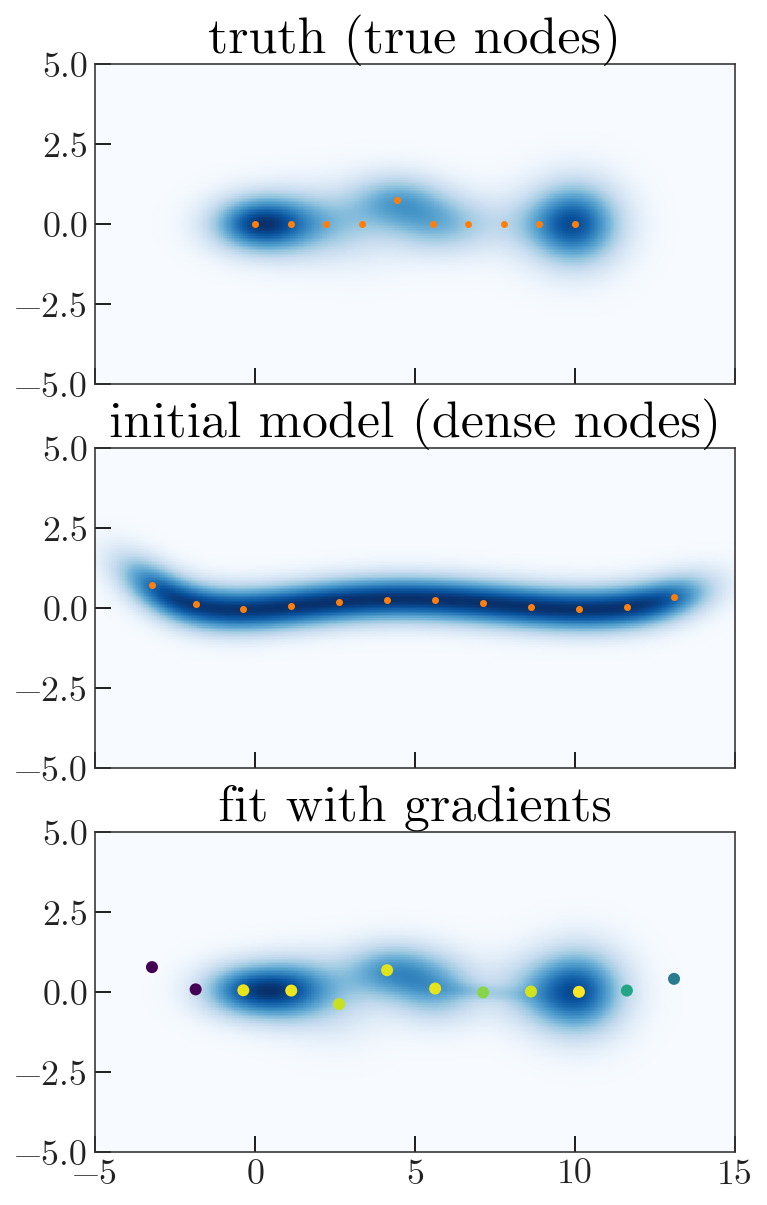

In [221]:
bins = (np.arange(-10, 15+1e-3, 0.05),
        np.arange(-5, 5+1e-3, 0.05))
x, y = np.meshgrid(*bins)
xy = np.stack((x.ravel(), y.ravel())).T

fig, axes = plt.subplots(3, 1, figsize=(10, 10), 
                         sharex=True, sharey=True)

ax = axes[0]
ln_dens = true_dens_model.ln_density(xy, true_a, true_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(true_nodes[:, 0], true_nodes[:, 1],
           marker='.', color='tab:orange')

ax = axes[1]
med_p = model.unpack_pars(x0)
med_a = model.get_a(med_p)
med_s = model.get_s(med_p)
ln_dens = dens_model.ln_density(xy, med_a, med_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(dens_model.nodes[:, 0], dens_model.nodes[:, 1],
           marker='.', color='tab:orange')

ax = axes[2]
med_p = model.unpack_pars(res.x)
med_a = model.get_a(med_p)
med_s = model.get_s(med_p)
med_mu = model.get_mu(med_p)
ln_dens = dens_model.ln_density(xy, med_a, med_s, h=h, nodes=med_mu)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')
ax.scatter(med_mu[:, 0], med_mu[:, 1],
           marker='o', c=np.log(med_a))

for ax in axes:
    ax.set_aspect('equal')
    ax.set_xlim(-5, 15)

axes[0].set_title('truth (true nodes)')
axes[1].set_title('initial model (dense nodes)')
axes[2].set_title('fit with gradients')

fig.savefig('../plots/wiggle.png', dpi=250)

---

## Sample

In [281]:
import emcee

In [287]:
sampler = emcee.EnsembleSampler(nwalkers=64, ndim=x0.size, 
                                log_prob_fn=model.ln_posterior)

In [288]:
x0s = emcee.utils.sample_ball(true_x, [1e-7]*x0.size, size=64)

In [289]:
_ = sampler.run_mcmc(x0s, nsteps=256, progress=True)

100%|██████████| 256/256 [00:25<00:00, 10.18it/s]


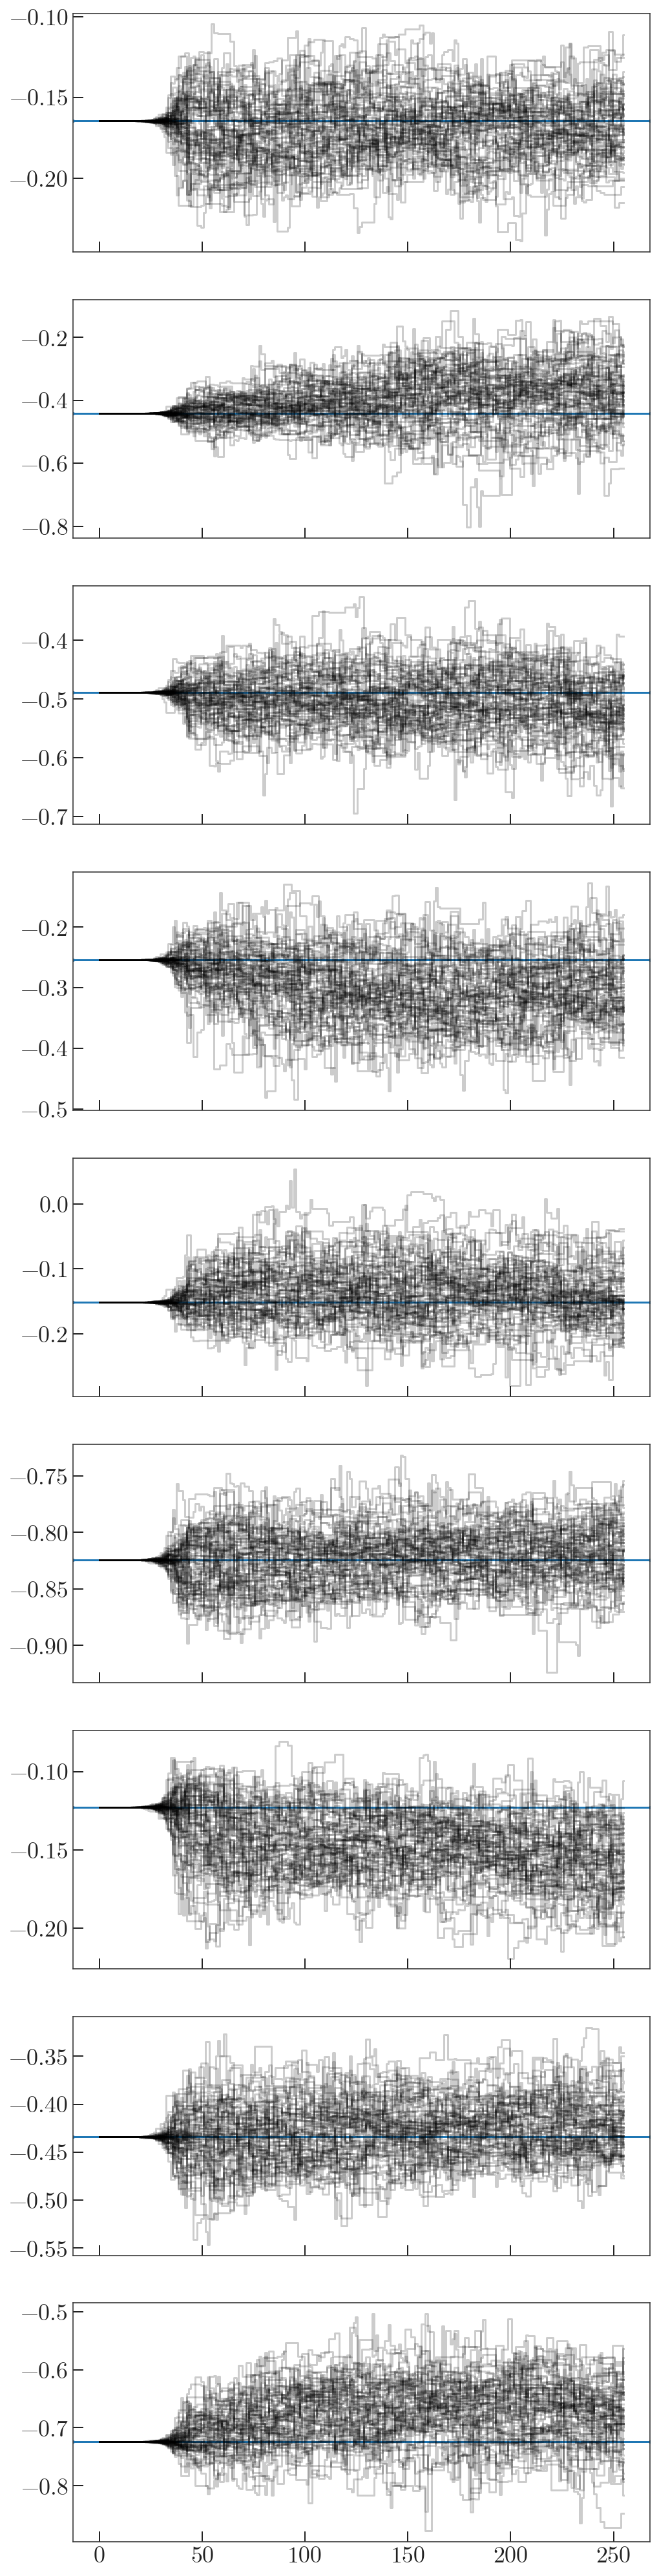

In [290]:
fig, axes = plt.subplots(x0.size, 1, figsize=(8, 4*x0.size), 
                         sharex=True)
for k in range(sampler.chain.shape[-1]):
    ax = axes[k]
    for walker in sampler.chain[..., k]:
        ax.plot(walker, marker='', drawstyle='steps-mid', color='k', alpha=0.2)
    ax.axhline(true_x[k], zorder=-10, color='tab:blue')

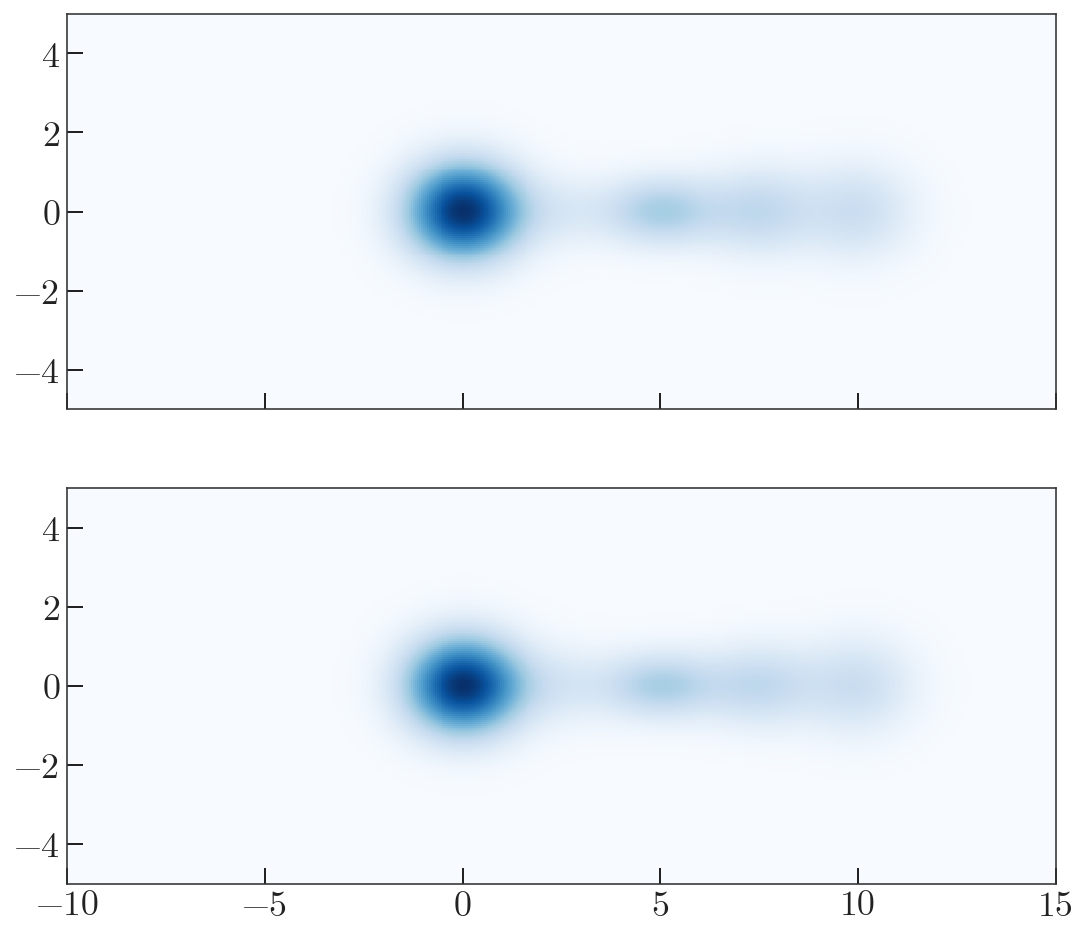

In [291]:
bins = (np.arange(-10, 15+1e-3, 0.05),
        np.arange(-5, 5+1e-3, 0.05))
x, y = np.meshgrid(*bins)
xy = np.stack((x.ravel(), y.ravel())).T

fig, axes = plt.subplots(2, 1, figsize=(10, 8), 
                         sharex=True, sharey=True)

ax = axes[0]
ln_dens = dens_model.ln_density(xy, true_a, true_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')

ax = axes[1]
med_p = model.unpack_pars(np.median(sampler.chain[:, -1], axis=0))
med_a = model.get_a(med_p)
med_s = model.get_s(med_p)
ln_dens = dens_model.ln_density(xy, med_a, med_s, h=h)
ax.pcolormesh(x, y, np.exp(ln_dens.reshape(x.shape) - ln_dens.max()),
              cmap='Blues')

for ax in axes:
    ax.set_aspect('equal')